In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '51-efficientnetb6'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'
SUBMISSION_TTA_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_blend.csv'


import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [ ]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers
# import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [7]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 16 * 8,
  "EPOCHS": 12,
  "LEARNING_RATE": 2e-5 * 8,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 3,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'EfficientNetB6',
  "BASE_MODEL_WEIGHTS": 'imagenet',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB6',
 'BASE_MODEL_WEIGHTS': 'imagenet',
 'BATCH_SIZE': 128,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 12,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.00016,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 3,
 'TTA_STEPS': 25,
 'WIDTH': 256}

# Load data

In [8]:
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-c2f318ab381f072971d2adb35fbd1cf6f734c11ee731b63b7915ac3e'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [9]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .6:
        if p_spatial2 >= .9:
            image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'], 180.)
        elif p_spatial2 >= .8:
            image['input_image'] = transform_zoom(image['input_image'], config['HEIGHT'], 8., 8.)
        elif p_spatial2 >= .7:
            image['input_image'] = transform_shift(image['input_image'], config['HEIGHT'], 8., 8.)
        else:
            image['input_image'] = transform_shear(image['input_image'], config['HEIGHT'], 2.)
        
    if p_crop >= .6: # crops
        if p_crop >= .8:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.8)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    if p_pixel >= .6: # Pixel-level transforms
        if p_pixel >= .9:
            image['input_image'] = tf.image.random_hue(image['input_image'], 0.01)
        elif p_pixel >= .8:
            image['input_image'] = tf.image.random_saturation(image['input_image'], 0.7, 1.3)
        elif p_pixel >= .7:
            image['input_image'] = tf.image.random_contrast(image['input_image'], 0.8, 1.2)
        else:
            image['input_image'] = tf.image.random_brightness(image['input_image'], 0.1)

    return image, label

## Auxiliary functions

In [10]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.normal([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.normal([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shift(image, height, h_shift, w_shift):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = h_shift * tf.random.normal([1],dtype='float32') 
    width_shift = w_shift * tf.random.normal([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_zoom(image, height, h_zoom, w_zoom):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly zoomed
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_zoom = 1.0 + tf.random.normal([1],dtype='float32')/h_zoom
    width_zoom = 1.0 + tf.random.normal([1],dtype='float32')/w_zoom
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(zoom_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

## Learning rate scheduler

Learning rate schedule: 5e-06 to 0.00016 to 4.19e-05


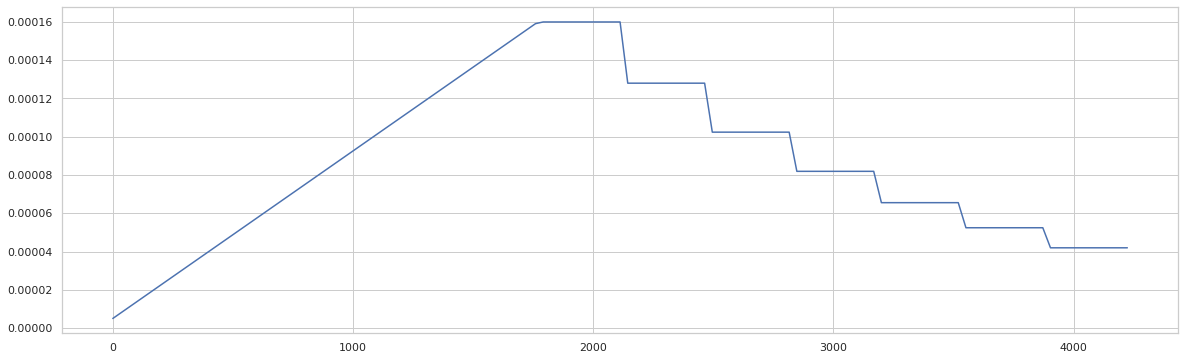

In [14]:
#@title
lr_min = 1e-6
lr_start = 5e-6
lr_max = config['LEARNING_RATE']
steps_per_epoch = 45365 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
hold_max_steps = 0
step_decay = .8
step_size = steps_per_epoch * 1

rng = [i for i in range(0, total_steps, 32)]
y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
                               warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                               lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [15]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB6(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [16]:
# Evaluation
# eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=512, buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Test
# test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
# test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=512, buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=512, buffer_size=AUTO, tta=True)
test_image_data = test_dataset.map(lambda data, image_name: data)
test_tta_image_data = test_dataset_tta.map(lambda data, image_name: data)

NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta_last = np.zeros((NUM_TEST_IMAGES, 1))


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: step_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                   step_size=step_size, warmup_steps=warmup_steps, 
                                                   hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                   lr_max=lr_max, step_decay=step_decay)
        
            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer=optimizer, 
                          loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch ,
                            callbacks=[checkpoint, es], 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Last model inference...')
        test_preds_last += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (last) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta_last += model.predict(test_tta_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Best model inference...')
        test_preds += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (best) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta += model.predict(test_tta_image_data)


# normalize preds
test_preds /= config['N_USED_FOLDS']
test_preds_tta /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= config['N_USED_FOLDS']
test_preds_tta_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_tta = dict(zip(image_names_test, test_preds_tta.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))
name_preds_tta_last = dict(zip(image_names_test, test_preds_tta_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_tta'] = test.apply(lambda x: name_preds_tta[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)
test['target_tta_last'] = test.apply(lambda x: name_preds_tta_last[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.33.25.2:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.33.25.2:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


165527552/165527152 [==============================] - 2s 0us/step
Epoch 1/12
375/375 - 152s - loss: 0.4178 - auc: 0.6805 - val_loss: 0.2798 - val_auc: 0.8761
Epoch 2/12
375/375 - 131s - loss: 0.2859 - auc: 0.8588 - val_loss: 0.2578 - val_auc: 0.9131
Epoch 3/12
375/375 - 135s - loss: 0.2663 - auc: 0.8933 - val_loss: 0.2481 - val_auc: 0.9187
Epoch 4/12
375/375 - 131s - loss: 0.2575 - auc: 0.9084 - val_loss: 0.2397 - val_auc: 0.9294
Epoch 5/12
375/375 - 132s - loss: 0.2480 - auc: 0.9198 - val_loss: 0.2305 - val_auc: 0.9400
Epoch 6/12
375/375 - 132s - loss: 0.2400 - auc: 0.9308 - val_loss: 0.2232 - val_auc: 0.9462
Epoch 7/12
375/375 - 132s - loss: 0.2262 - auc: 0.9429 - val_loss: 0.2207 - val_auc: 0.9476
Epoch 8/12
375/375 - 132s - loss: 0.2205 - auc: 0.9497 - val_loss: 0.2164 - val_auc: 0.9554
Epoch 9/12
375/375 - 132s - loss: 0.2101 - auc: 0.9588 - val_loss: 0.2120 - val_auc: 0.9553
Epoch 10/12
375/375 - 132s - loss: 0.2022 - auc: 0.9649 - val_loss: 0.2115 - val_auc: 0.9544
Epoch 11/12


INFO:tensorflow:Initializing the TPU system: grpc://10.33.25.2:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.33.25.2:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
375/375 - 157s - loss: 0.4159 - auc: 0.6658 - val_loss: 0.2837 - val_auc: 0.8805
Epoch 2/12
375/375 - 133s - loss: 0.2829 - auc: 0.8615 - val_loss: 0.2602 - val_auc: 0.9082
Epoch 3/12
375/375 - 133s - loss: 0.2669 - auc: 0.8908 - val_loss: 0.2425 - val_auc: 0.9299
Epoch 4/12
375/375 - 133s - loss: 0.2555 - auc: 0.9077 - val_loss: 0.2375 - val_auc: 0.9334
Epoch 5/12
375/375 - 132s - loss: 0.2476 - auc: 0.9186 - val_loss: 0.2361 - val_auc: 0.9370
Epoch 6/12
375/375 - 132s - loss: 0.2390 - auc: 0.9289 - val_loss: 0.2274 - val_auc: 0.9453
Epoch 7/12
375/375 - 133s - loss: 0.2282 - auc: 0.9422 - val_loss: 0.2218 - val_auc: 0.9496
Epoch 8/12
375/375 - 133s - loss: 0.2191 - auc: 0.9489 - val_loss: 0.2170 - val_auc: 0.9547
Epoch 9/12
375/375 - 133s - loss: 0.2101 - auc: 0.9575 - val_loss: 0.2119 - val_auc: 0.9549
Epoch 10/12
375/375 - 132s - loss: 0.2022 - auc: 0.9647 - val_loss: 0.2095 - val_auc: 0.9555
Epoch 11/12
375/375 - 133s - loss: 0.1986 - auc: 0.9679 - val_loss: 0.2070 - va

INFO:tensorflow:Initializing the TPU system: grpc://10.33.25.2:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.33.25.2:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
388/388 - 157s - loss: 0.4083 - auc: 0.6859 - val_loss: 0.2925 - val_auc: 0.8518
Epoch 2/12
388/388 - 135s - loss: 0.2829 - auc: 0.8620 - val_loss: 0.2673 - val_auc: 0.9010
Epoch 3/12
388/388 - 136s - loss: 0.2648 - auc: 0.8940 - val_loss: 0.2550 - val_auc: 0.9183
Epoch 4/12
388/388 - 136s - loss: 0.2532 - auc: 0.9124 - val_loss: 0.2454 - val_auc: 0.9290
Epoch 5/12
388/388 - 136s - loss: 0.2450 - auc: 0.9225 - val_loss: 0.2393 - val_auc: 0.9357
Epoch 6/12
388/388 - 135s - loss: 0.2341 - auc: 0.9350 - val_loss: 0.2352 - val_auc: 0.9440
Epoch 7/12
388/388 - 137s - loss: 0.2241 - auc: 0.9458 - val_loss: 0.2302 - val_auc: 0.9436
Epoch 8/12
388/388 - 136s - loss: 0.2142 - auc: 0.9533 - val_loss: 0.2223 - val_auc: 0.9500
Epoch 9/12
388/388 - 136s - loss: 0.2059 - auc: 0.9626 - val_loss: 0.2217 - val_auc: 0.9509
Epoch 10/12
388/388 - 136s - loss: 0.2009 - auc: 0.9669 - val_loss: 0.2210 - val_auc: 0.9511
Epoch 11/12
388/388 - 136s - loss: 0.1955 - auc: 0.9710 - val_loss: 0.2179 - va

## Model loss graph

Fold: 1


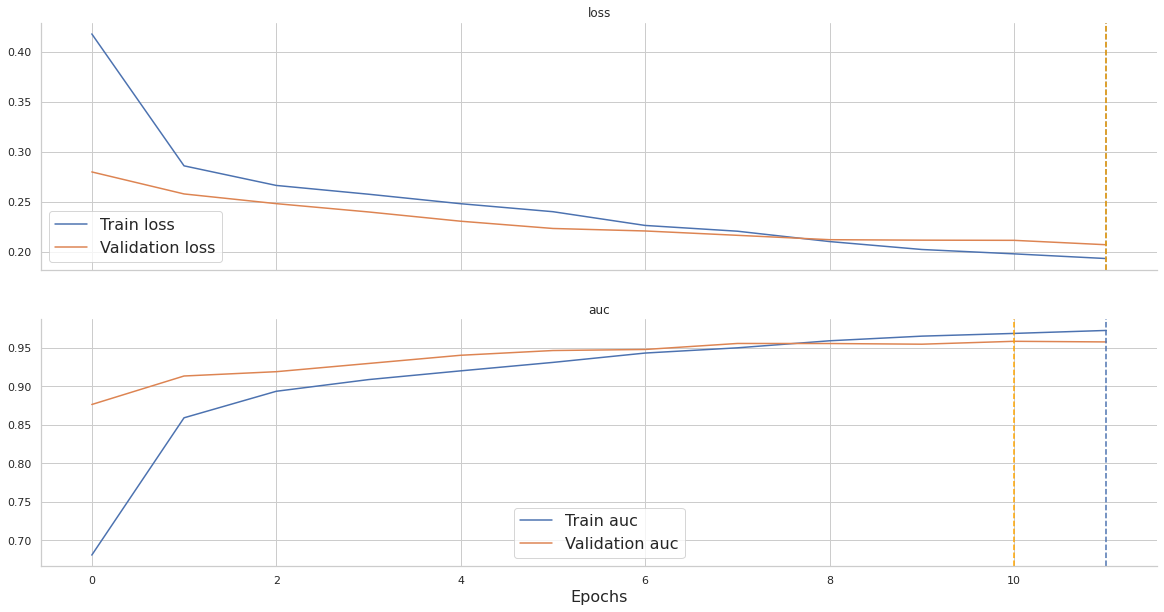

Fold: 2


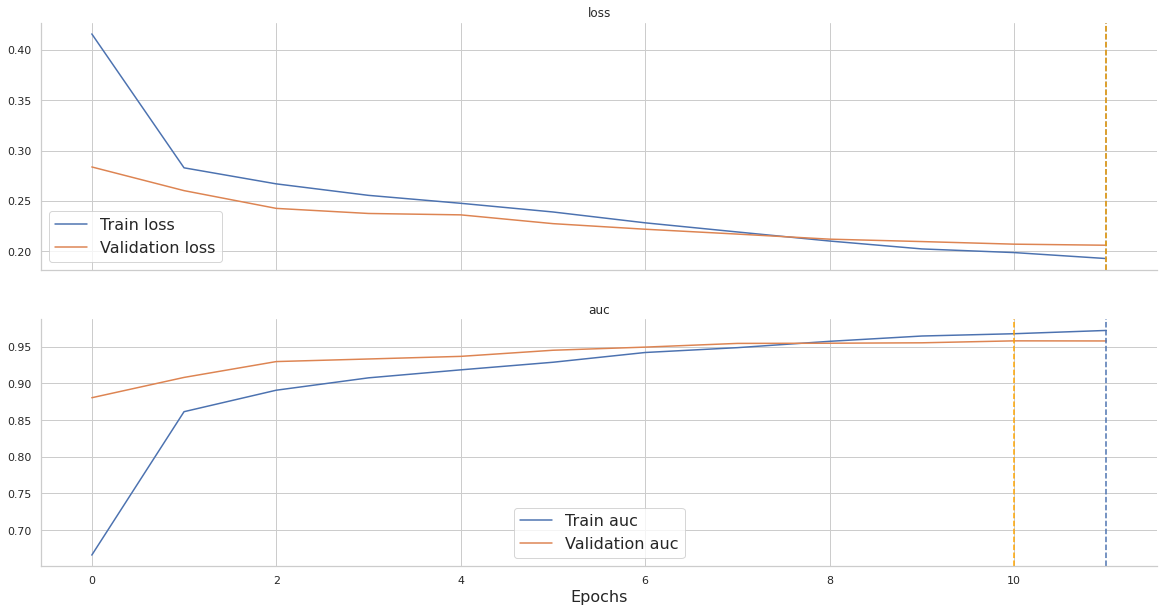

Fold: 3


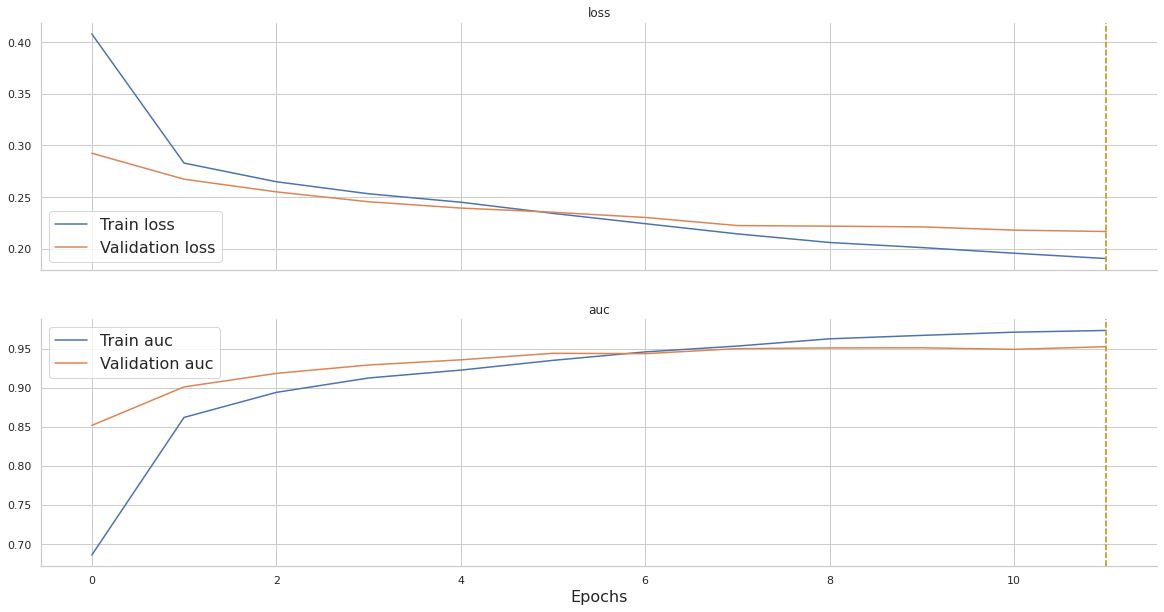

In [17]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

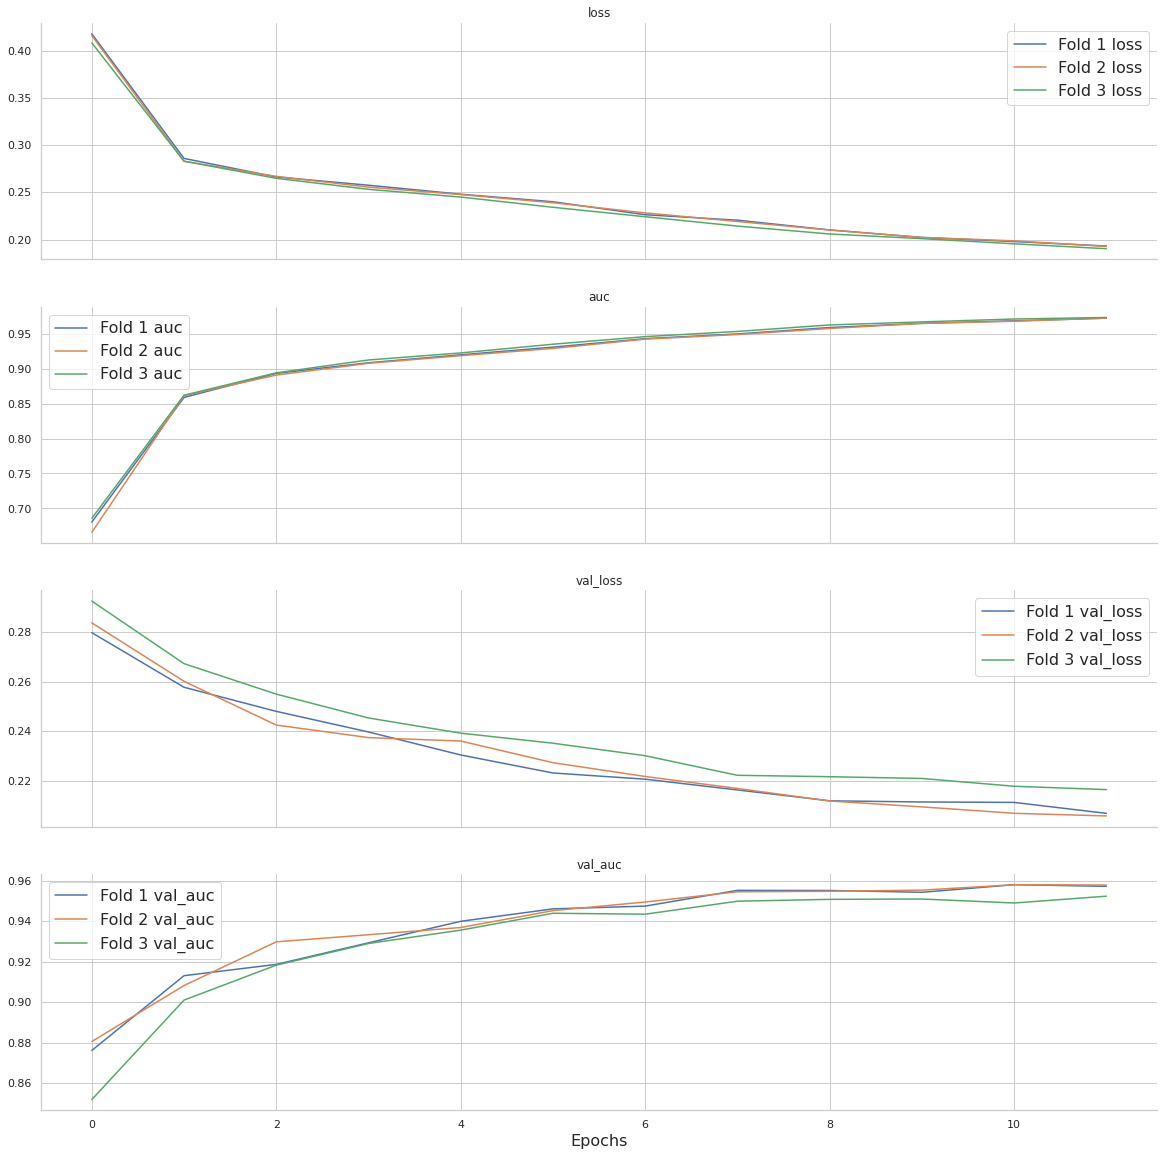

In [18]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [19]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.981201,0.893561,0.087639,0.983212,0.912537,0.980812,0.893880,0.979577,0.874266
Accuracy,0.990328,0.982405,0.007923,0.990447,0.983842,0.990014,0.982180,0.990523,0.981193
Precision,0.870488,0.504769,0.365719,0.878788,0.478261,0.867159,0.508772,0.865517,0.527273
Recall,0.529957,0.232566,0.297391,0.547170,0.205607,0.508658,0.237705,0.534043,0.254386
F1-score,0.658715,0.318266,0.340449,0.674419,0.287582,0.641201,0.324022,0.660526,0.343195
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


# Model evaluation by Subset

In [20]:
#@title
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.981201,0.893561,0.087639,0.983212,0.912537,0.980812,0.893880,0.979577,0.874266
male,0.983395,0.907422,0.075973,0.984798,0.932694,0.982960,0.918728,0.982426,0.870844
female,0.977601,0.862499,0.115102,0.980498,0.873717,0.976913,0.842700,0.975394,0.871081
head/neck,0.986678,0.879980,0.106697,0.985417,0.935536,0.985175,0.816441,0.989440,0.887964
upper extremity,0.984648,0.877271,0.107377,0.986237,0.945141,0.985898,0.837015,0.981809,0.849658
lower extremity,0.976256,0.853322,0.122933,0.977391,0.863300,0.977282,0.850193,0.974093,0.846474
torso,0.980219,0.918121,0.062098,0.983340,0.917163,0.979255,0.942242,0.978063,0.894959
0 <= age < 26,0.969317,0.882876,0.086441,0.976072,0.917935,0.971950,0.804303,0.959929,0.926389
26 <= age < 40,0.979476,0.810904,0.168573,0.991726,0.744307,0.964379,0.835940,0.982324,0.852464


# Model evaluation (best)

In [21]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.981421,0.893983,0.087438,0.983343,0.913265,0.981123,0.895313,0.979797,0.873371
Accuracy,0.990252,0.982284,0.007968,0.990220,0.983694,0.989976,0.982474,0.990560,0.980685
Precision,0.869723,0.498134,0.371590,0.868687,0.468085,0.869403,0.526316,0.871080,0.500000
Recall,0.525708,0.232374,0.293334,0.540881,0.205607,0.504329,0.245902,0.531915,0.245614
F1-score,0.655175,0.316774,0.338401,0.666667,0.285714,0.638356,0.335196,0.660502,0.329412
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.981421,0.893983,0.087438,0.983343,0.913265,0.981123,0.895313,0.979797,0.873371
male,0.983545,0.907143,0.076402,0.984958,0.932659,0.982963,0.918758,0.982715,0.870013
female,0.977930,0.864349,0.113581,0.980548,0.876197,0.977731,0.846880,0.975511,0.869969
head/neck,0.987255,0.880774,0.106481,0.985393,0.936664,0.987204,0.820596,0.989167,0.885062
upper extremity,0.984956,0.876760,0.108196,0.986272,0.945187,0.986539,0.835326,0.982056,0.849767
lower extremity,0.976146,0.855396,0.120750,0.977110,0.866383,0.977185,0.856111,0.974143,0.843694
torso,0.980390,0.918271,0.062119,0.983686,0.916644,0.979051,0.942894,0.978433,0.895274
0 <= age < 26,0.969565,0.880903,0.088661,0.975161,0.914674,0.972132,0.803962,0.961402,0.924074
26 <= age < 40,0.980976,0.814329,0.166647,0.991567,0.749152,0.968620,0.839179,0.982741,0.854655


# Confusion matrix

Fold: 1


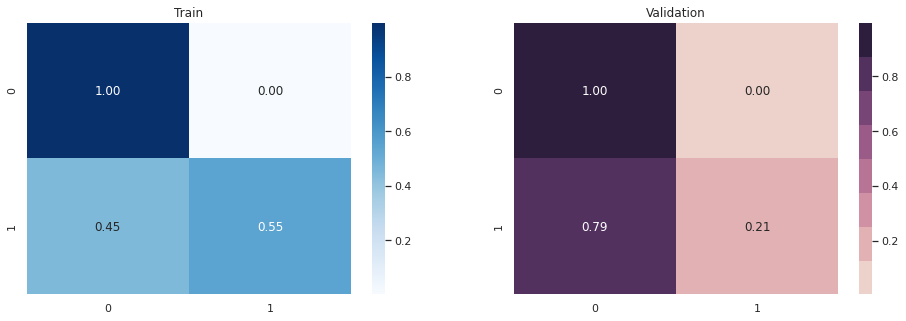

Fold: 2


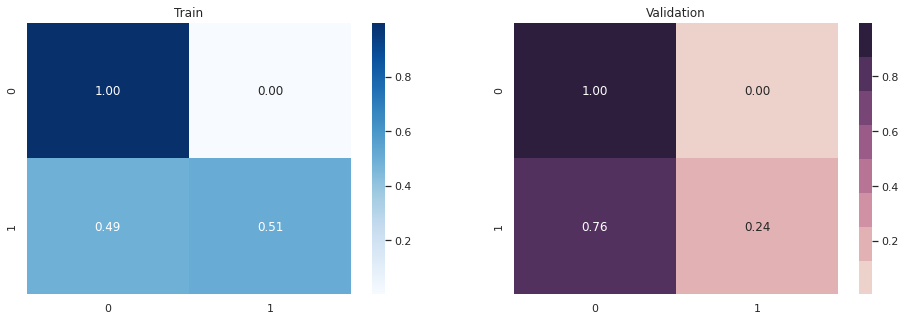

Fold: 3


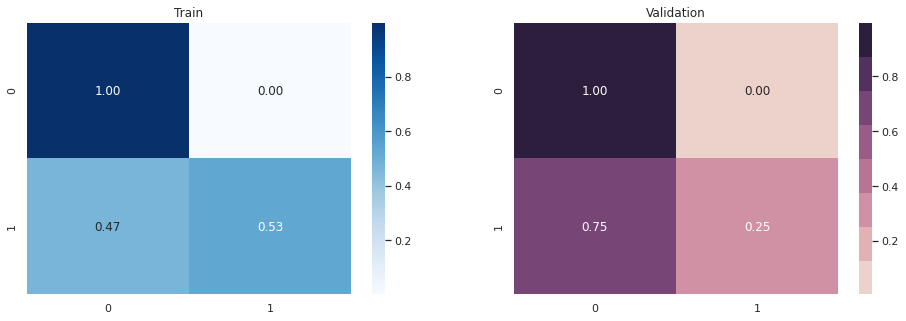

In [22]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [23]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 121
Train positive correct predictions: 117
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.022400,0.022944,0.066148,0.022909
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.013096,0.022351,0.023475,0.019653
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.015498,0.025133,0.023243,0.029112
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.014837,0.027069,0.024701,0.022414
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.017201,0.018687,0.027702,0.039616
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.017292,0.031562,0.026038,0.028860
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.021325,0.038868,0.045768,0.021987
7,ISIC_0075663,female,35.0,torso,unknown,0,0.015020,0.023553,0.025036,0.026509
8,ISIC_0075914,male,30.0,torso,unknown,0,0.018423,0.022686,0.035117,0.034311
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.018470,0.031184,0.024857,0.036307


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.045629,0.061074,0.099805,0.067265
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.210884,0.418985,0.119868,0.515567
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.146258,0.298156,0.086604,0.346532
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.238530,0.279815,0.118964,0.793873
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.429816,0.509402,0.875414,0.764264
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.555847,0.800593,0.992301,0.986339
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.056096,0.147112,0.059524,0.073842
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.154997,0.076797,0.346759,0.351431
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.261793,0.173109,0.743079,0.392774
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.072202,0.251195,0.072869,0.036948


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.555847,0.800593,0.992301,0.986339
758,ISIC_0333091,male,25.0,lower extremity,melanoma,1,0.587104,0.959416,0.987841,0.988261
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.584186,0.973362,0.969460,0.978108
1335,ISIC_0504165,female,60.0,lower extremity,melanoma,1,0.525786,0.915078,0.835778,0.878074
1742,ISIC_0624498,female,80.0,torso,melanoma,1,0.517289,0.782224,0.867075,0.937146
1790,ISIC_0639769,male,65.0,head/neck,melanoma,1,0.589929,0.982203,0.985459,0.981982
2485,ISIC_0844312,male,75.0,head/neck,melanoma,1,0.589642,0.971184,0.985480,0.991547
2542,ISIC_0862745,female,75.0,head/neck,melanoma,1,0.571528,0.898621,0.981105,0.977912
2709,ISIC_0911264,male,65.0,lower extremity,melanoma,1,0.578926,0.942038,0.985110,0.967481
2753,ISIC_0924427,male,65.0,head/neck,melanoma,1,0.557974,0.864116,0.963228,0.962525


# Visualize test predictions

In [24]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions (tta) {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last tta) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 145|10837
Test predictions (last) 144|10838
Test predictions (tta) 130|10852
Test predictions (last tta) 136|10846
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.028796,0.028880,0.029706,0.030322
1,ISIC_0052349,male,40.0,lower extremity,0.025813,0.026071,0.027732,0.027678
2,ISIC_0058510,female,55.0,torso,0.052194,0.051704,0.040563,0.038482
3,ISIC_0073313,female,50.0,torso,0.025830,0.026018,0.027427,0.027237
4,ISIC_0073502,female,45.0,lower extremity,0.040353,0.040251,0.032043,0.033355
5,ISIC_0074618,male,50.0,lower extremity,0.030459,0.030086,0.035069,0.035503
6,ISIC_0076801,male,45.0,upper extremity,0.025189,0.024962,0.023267,0.022638
7,ISIC_0077586,male,50.0,lower extremity,0.032071,0.031309,0.039972,0.041233
8,ISIC_0082004,female,45.0,torso,0.024233,0.024060,0.024097,0.023466
9,ISIC_0082785,male,65.0,lower extremity,0.030250,0.030357,0.027021,0.027079


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.633115,0.632796,0.762051,0.735240
42,ISIC_0155983,male,70.0,torso,0.555032,0.553971,0.520532,0.544597
102,ISIC_0208233,female,60.0,lower extremity,0.993062,0.993230,0.984377,0.985196
192,ISIC_0287325,male,60.0,torso,0.594160,0.598608,0.439396,0.443481
255,ISIC_0351156,male,40.0,head/neck,0.636100,0.642062,0.346382,0.335433
296,ISIC_0391046,male,85.0,torso,0.806391,0.808136,0.786145,0.825116
390,ISIC_0470699,male,90.0,torso,0.684508,0.689289,0.817565,0.835991
403,ISIC_0481105,male,80.0,torso,0.560642,0.549761,0.719377,0.708947
471,ISIC_0539432,female,45.0,lower extremity,0.887047,0.884366,0.796575,0.828274
530,ISIC_0588352,male,60.0,lower extremity,0.608058,0.601137,0.483600,0.493635


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.633115,0.632796,0.762051,0.735240
42,ISIC_0155983,male,70.0,torso,0.555032,0.553971,0.520532,0.544597
102,ISIC_0208233,female,60.0,lower extremity,0.993062,0.993230,0.984377,0.985196
192,ISIC_0287325,male,60.0,torso,0.594160,0.598608,0.439396,0.443481
255,ISIC_0351156,male,40.0,head/neck,0.636100,0.642062,0.346382,0.335433
296,ISIC_0391046,male,85.0,torso,0.806391,0.808136,0.786145,0.825116
390,ISIC_0470699,male,90.0,torso,0.684508,0.689289,0.817565,0.835991
403,ISIC_0481105,male,80.0,torso,0.560642,0.549761,0.719377,0.708947
471,ISIC_0539432,female,45.0,lower extremity,0.887047,0.884366,0.796575,0.828274
530,ISIC_0588352,male,60.0,lower extremity,0.608058,0.601137,0.483600,0.493635


# Test set predictions

In [25]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
submission['target_tta'] = test['target_tta']
submission['target_tta_last'] = test['target_tta_last']
submission['target_tta_blend'] = (test['target_tta'] * .5) +  (test['target_tta_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

### TTA ###
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv(SUBMISSION_TTA_PATH, index=False)

### TTA LAST ###
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv(SUBMISSION_TTA_LAST_PATH, index=False)

### TTA BLEND ###
submission_blend_tta = submission[['image_name', 'target_tta_blend']]
submission_blend_tta.columns = ['image_name', 'target']
submission_blend_tta.to_csv(SUBMISSION_TTA_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
0,ISIC_0052060,0.028796,0.028880,0.028838,0.029706,0.030322,0.030014
1,ISIC_0052349,0.025813,0.026071,0.025942,0.027732,0.027678,0.027705
2,ISIC_0058510,0.052194,0.051704,0.051949,0.040563,0.038482,0.039522
3,ISIC_0073313,0.025830,0.026018,0.025924,0.027427,0.027237,0.027332
4,ISIC_0073502,0.040353,0.040251,0.040302,0.032043,0.033355,0.032699
5,ISIC_0074618,0.030459,0.030086,0.030273,0.035069,0.035503,0.035286
6,ISIC_0076801,0.025189,0.024962,0.025076,0.023267,0.022638,0.022952
7,ISIC_0077586,0.032071,0.031309,0.031690,0.039972,0.041233,0.040602
8,ISIC_0082004,0.024233,0.024060,0.024146,0.024097,0.023466,0.023781
9,ISIC_0082785,0.030250,0.030357,0.030304,0.027021,0.027079,0.027050


,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,0.055363,0.055366,0.055365,0.053583,0.053520,0.053552
std,0.097138,0.097077,0.097102,0.090296,0.090103,0.090167
min,0.015545,0.015448,0.015497,0.015268,0.015472,0.015370
25%,0.027552,0.027569,0.027582,0.027224,0.027241,0.027243
50%,0.032633,0.032635,0.032644,0.032563,0.032573,0.032591
75%,0.043656,0.043770,0.043720,0.043862,0.043964,0.043994
max,0.994897,0.995000,0.994948,0.990987,0.991180,0.991084
